
=== Logistic Regression ===
Training Accuracy: 0.8506
Testing Accuracy:  0.7574
              precision    recall  f1-score   support

    negative       0.90      0.77      0.83      1816
     neutral       0.53      0.68      0.60       612
    positive       0.69      0.79      0.74       458

    accuracy                           0.76      2886
   macro avg       0.70      0.75      0.72      2886
weighted avg       0.79      0.76      0.77      2886

AUC Value: 0.8904


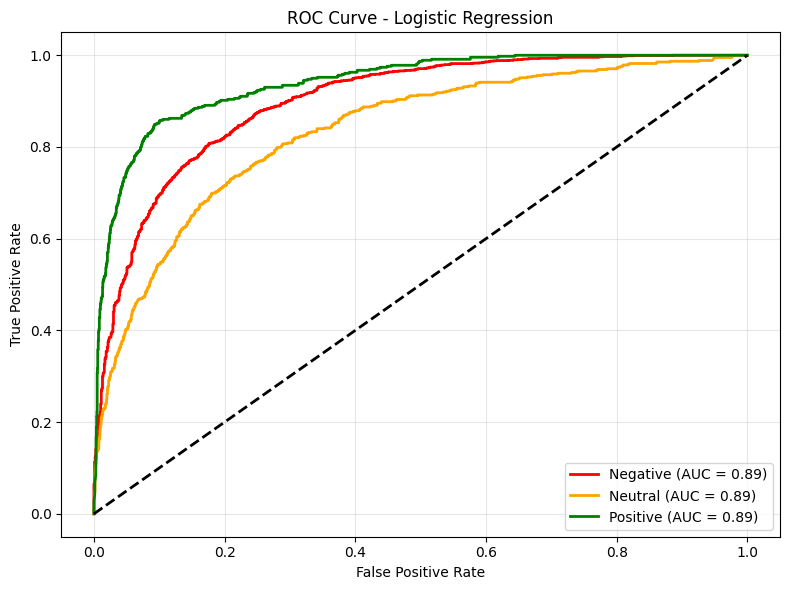


=== Support Vector Machine ===
Training Accuracy: 0.8601
Testing Accuracy:  0.7502
              precision    recall  f1-score   support

    negative       0.89      0.77      0.83      1816
     neutral       0.52      0.67      0.59       612
    positive       0.68      0.76      0.72       458

    accuracy                           0.75      2886
   macro avg       0.70      0.74      0.71      2886
weighted avg       0.78      0.75      0.76      2886

AUC Value: 0.8892


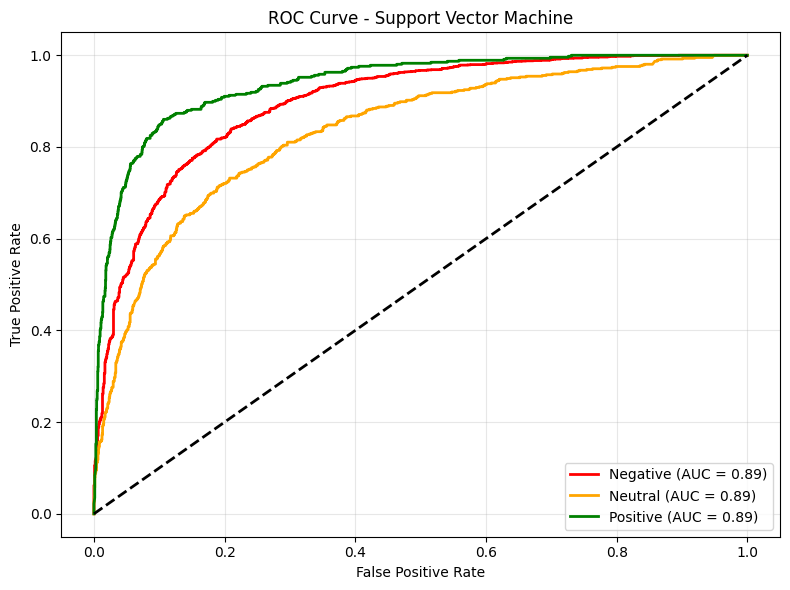


=== Random Forest ===
Training Accuracy: 0.9950
Testing Accuracy:  0.7654
              precision    recall  f1-score   support

    negative       0.81      0.89      0.85      1816
     neutral       0.61      0.49      0.54       612
    positive       0.72      0.63      0.68       458

    accuracy                           0.77      2886
   macro avg       0.71      0.67      0.69      2886
weighted avg       0.75      0.77      0.76      2886

AUC Value: 0.8722


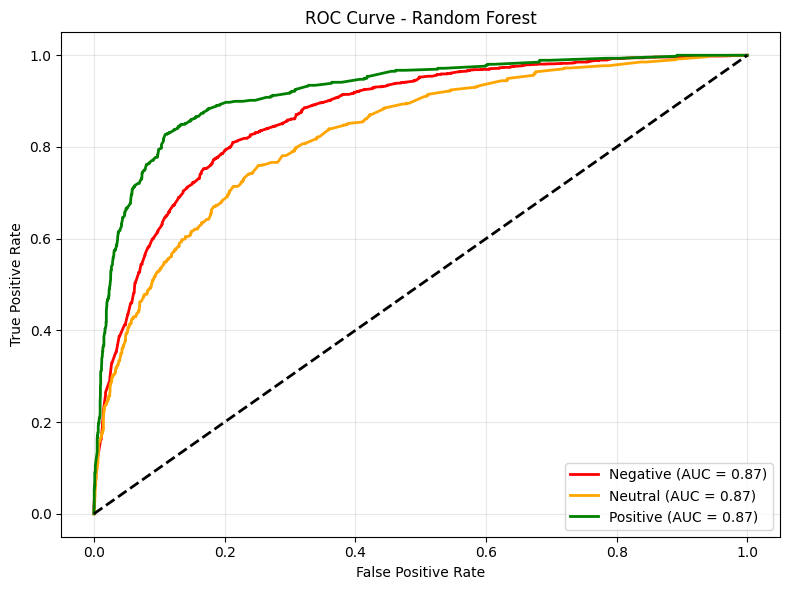

Epoch 1/5
325/325 - 20s - 62ms/step - accuracy: 0.6593 - loss: 0.8382 - val_accuracy: 0.7429 - val_loss: 0.6412
Epoch 2/5
325/325 - 18s - 57ms/step - accuracy: 0.7972 - loss: 0.5231 - val_accuracy: 0.7584 - val_loss: 0.6157
Epoch 3/5
325/325 - 20s - 63ms/step - accuracy: 0.8622 - loss: 0.3537 - val_accuracy: 0.7593 - val_loss: 0.6773
Epoch 4/5
325/325 - 15s - 47ms/step - accuracy: 0.9025 - loss: 0.2520 - val_accuracy: 0.7463 - val_loss: 0.7840
Epoch 5/5
325/325 - 16s - 48ms/step - accuracy: 0.9354 - loss: 0.1682 - val_accuracy: 0.7472 - val_loss: 0.9789
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

=== CNN Model ===
Training Accuracy: 0.9408
Testing Accuracy:  0.7568
              precision    recall  f1-score   support

    negative       0.87      0.81      0.84      1816
     neutral       0.57      0.59      0.58       612
    positive       0.63      0.78      0.70       458

    accuracy                           0.76      2886
   macro avg       0.69      0.73      0.70      2886
wei

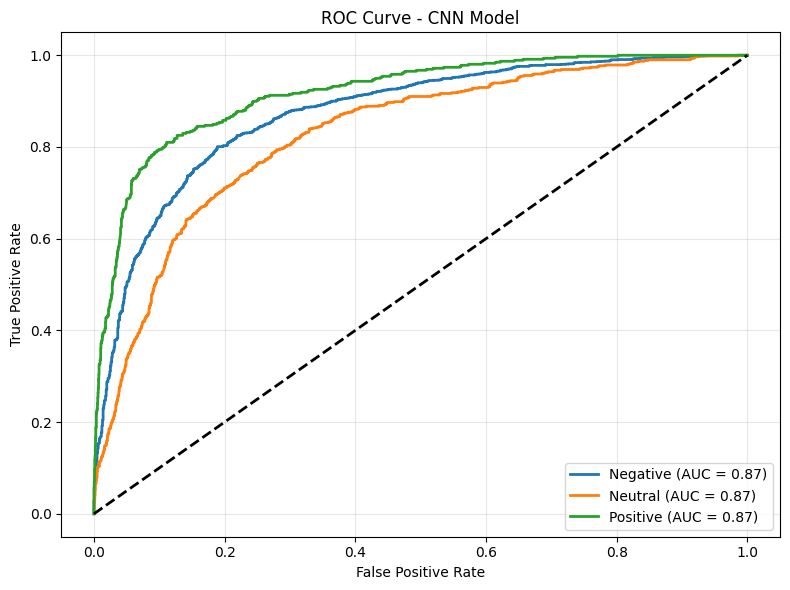

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/ThisIsMrIsmail/twitter-us-airline-sentiment-analysis/3bce8fc85f3dfd94f89e50ec6017d87ef6ec09c2/data/clean_Tweets.csv"
df = pd.read_csv(url)

sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(sentiment_map)
X_text = df['text']
y = df['label']

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Support Vector Machine': SVC(kernel='linear', probability=True, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy:  {test_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

    y_test_bin = label_binarize(y_test, classes=[0,1,2])
    auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
    print(f"AUC Value: {auc:.4f}")

    fpr = {}
    tpr = {}
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

    plt.figure(figsize=(8, 6))
    colors = ['red', 'orange', 'green']
    class_names = ['Negative', 'Neutral', 'Positive']
    for i in range(3):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f'ROC Curve - {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)
y_train_cnn_cat = to_categorical(y_train_cnn, num_classes=3)
y_test_cnn_cat = to_categorical(y_test_cnn, num_classes=3)

class_weights_cnn = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_cnn), y=y_train_cnn)
class_weights_cnn_dict = dict(enumerate(class_weights_cnn))

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(
    X_train_cnn, y_train_cnn_cat,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=2,
    class_weight=class_weights_cnn_dict
)

train_acc_cnn = cnn_model.evaluate(X_train_cnn, y_train_cnn_cat, verbose=0)[1]
test_acc_cnn = cnn_model.evaluate(X_test_cnn, y_test_cnn_cat, verbose=0)[1]

y_pred_cnn_prob = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)

print("\n=== CNN Model ===")
print(f"Training Accuracy: {train_acc_cnn:.4f}")
print(f"Testing Accuracy:  {test_acc_cnn:.4f}")
print(classification_report(y_test_cnn, y_pred_cnn, target_names=['negative', 'neutral', 'positive']))

auc_cnn = roc_auc_score(y_test_cnn_cat, y_pred_cnn_prob, multi_class='ovr')
print(f"AUC Value: {auc_cnn:.4f}")

fpr = {}
tpr = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_cnn_cat[:, i], y_pred_cnn_prob[:, i])

plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'green']
class_names = ['Negative', 'Neutral', 'Positive']
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC Curve - CNN Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


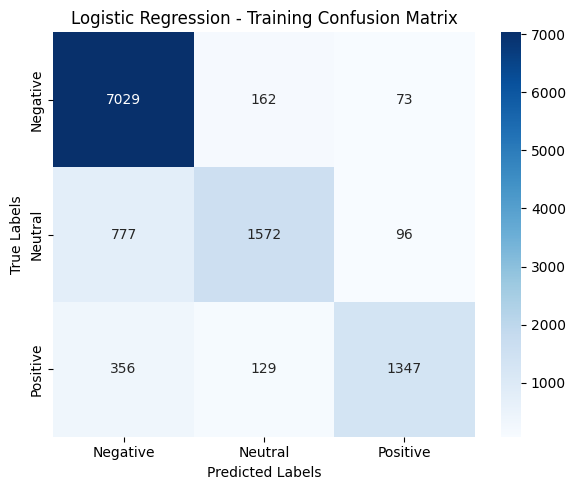

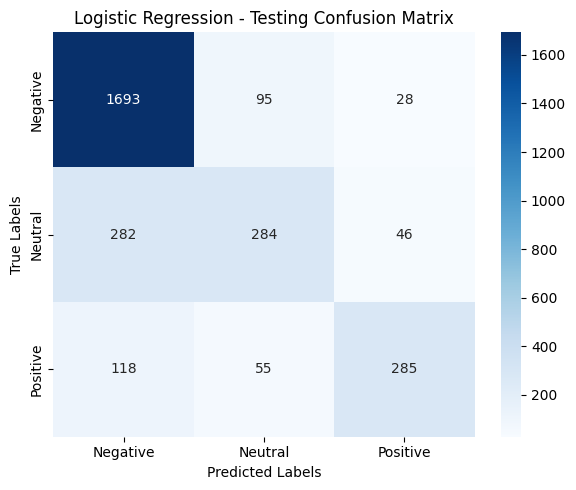

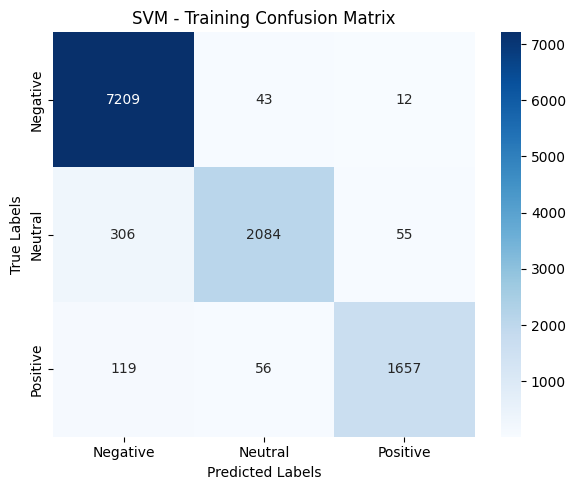

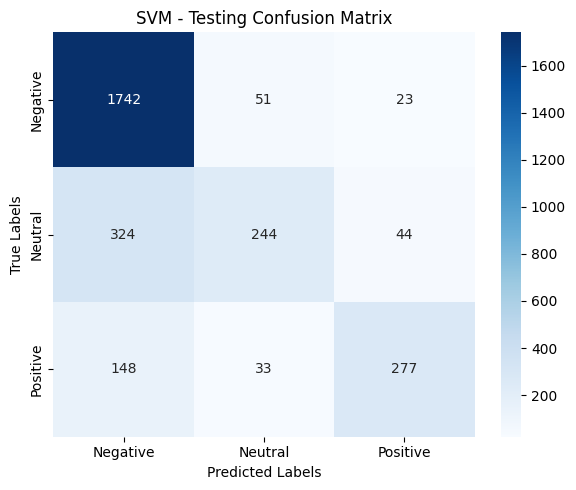

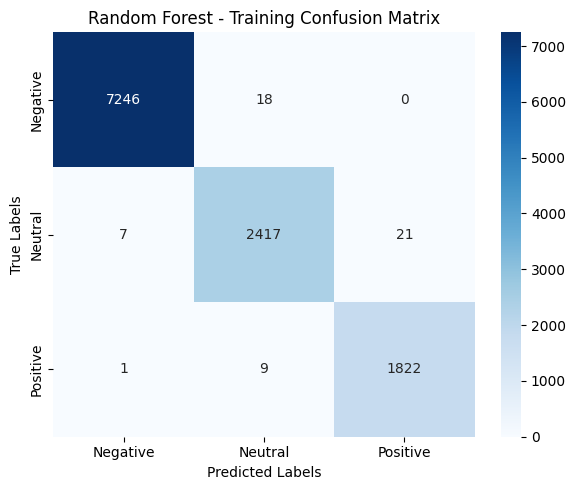

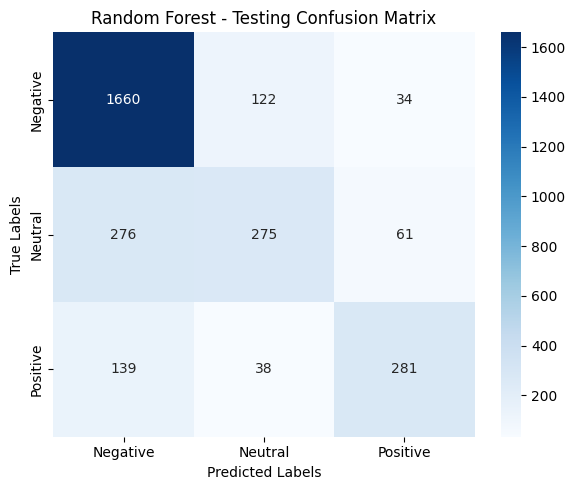

361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


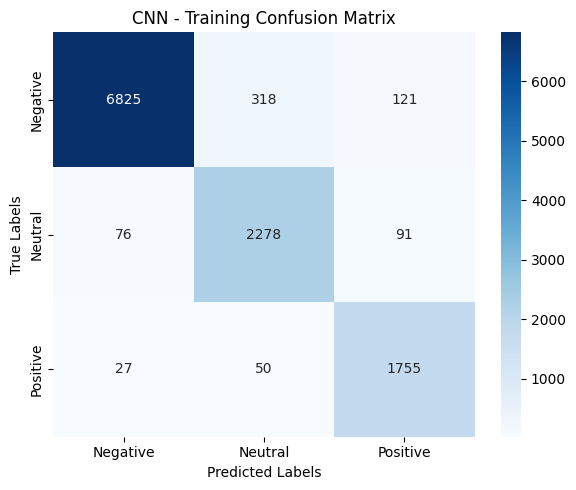

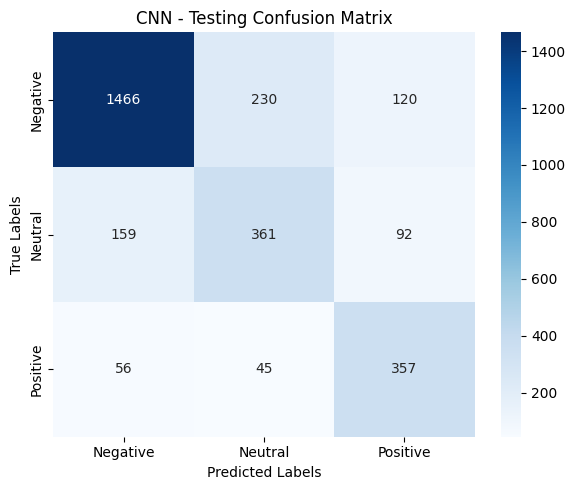

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

svm_model = SVC()
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Logistic Regression
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

plot_conf_matrix(y_train, y_train_pred_lr, title='Logistic Regression - Training Confusion Matrix')
plot_conf_matrix(y_test, y_test_pred_lr, title='Logistic Regression - Testing Confusion Matrix')

# Support Vector Machine
y_train_pred_svm = svm_model.predict(X_train)
y_test_pred_svm = svm_model.predict(X_test)

plot_conf_matrix(y_train, y_train_pred_svm, title='SVM - Training Confusion Matrix')
plot_conf_matrix(y_test, y_test_pred_svm, title='SVM - Testing Confusion Matrix')

# Random Forest
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

plot_conf_matrix(y_train, y_train_pred_rf, title='Random Forest - Training Confusion Matrix')
plot_conf_matrix(y_test, y_test_pred_rf, title='Random Forest - Testing Confusion Matrix')

y_train_pred_cnn = np.argmax(cnn_model.predict(X_train_cnn), axis=1)
y_test_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

plot_conf_matrix(y_train_cnn, y_train_pred_cnn, title='CNN - Training Confusion Matrix')
plot_conf_matrix(y_test_cnn, y_test_pred_cnn, title='CNN - Testing Confusion Matrix')
